# Data Science Salary Analysis Questions

### Features
- **work_year**: The year of the data related to the job salary.
- **experience_level**: The level of experience of the employee (e.g., entry-level, mid-level, senior-level).
- **employment_type**: The type of employment (e.g., full-time, part-time, contract).
- **job_title**: The title or role of the employee within the data science field.
- **salary**: The salary of the employee.
- **salary_currency**: The currency in which the salary is denoted.
- **salary_in_usd**: The salary converted to US dollars for standardization.
- **employee_residence**: The residence location of the employee.
- **remote_ratio**: The ratio of remote work allowed for the position.
- **company_location**: The location of the company.
- **company_size**: The size of the company based on employee count or revenue.

## Data Setup

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter, ScalarFormatter

df = pd.read_csv('DataScience_salaries_2024.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021,MI,FT,Data Scientist,30400000,CLP,40038,CL,100,CL,L
1,2021,MI,FT,BI Data Analyst,11000000,HUF,36259,HU,50,US,L
2,2020,MI,FT,Data Scientist,11000000,HUF,35735,HU,50,HU,L
3,2021,MI,FT,ML Engineer,8500000,JPY,77364,JP,50,JP,S
4,2022,SE,FT,Lead Machine Learning Engineer,7500000,INR,95386,IN,50,IN,L


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14838 entries, 0 to 14837
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           14838 non-null  int64 
 1   experience_level    14838 non-null  object
 2   employment_type     14838 non-null  object
 3   job_title           14838 non-null  object
 4   salary              14838 non-null  int64 
 5   salary_currency     14838 non-null  object
 6   salary_in_usd       14838 non-null  int64 
 7   employee_residence  14838 non-null  object
 8   remote_ratio        14838 non-null  int64 
 9   company_location    14838 non-null  object
 10  company_size        14838 non-null  object
dtypes: int64(4), object(7)
memory usage: 1.2+ MB


In [24]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,14838.000000,1.483800e+04,14838.000000,14838.000000
mean,2023.138900,1.650227e+05,149874.718763,32.760480
std,0.700799,3.562354e+05,69009.181349,46.488278
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2023.000000,1.021000e+05,102000.000000,0.000000
50%,2023.000000,1.422000e+05,141300.000000,0.000000
75%,2024.000000,1.875000e+05,185900.000000,100.000000
max,2024.000000,3.040000e+07,800000.000000,100.000000


## Removing outliers

In [25]:
def remove_outliers_std(df, num_std=3, exclude_col=None):
    """
    Remove outliers from a pandas DataFrame using the standard deviation method, 
    with an option to exclude a specific column from being considered for outlier removal.
    
    Parameters:
    - df: pandas DataFrame from which outliers will be removed.
    - num_std: Number of standard deviations from the mean. Values outside
               this range will be considered outliers. Default is 3.
    - exclude_col: Name of the column to exclude from outlier consideration. Default is None.
    
    Returns:
    - A new DataFrame with outliers removed from numeric columns, except for the excluded column.
    """

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if exclude_col and exclude_col in numeric_cols:
        numeric_cols.remove(exclude_col)
    
    mean = df[numeric_cols].mean()
    std = df[numeric_cols].std()
    
    non_outlier_condition = ((df[numeric_cols] >= (mean - num_std * std)) & 
                             (df[numeric_cols] <= (mean + num_std * std)))
    
    # Apply the condition across rows (axis=1) and keep rows where all conditions are True
    return df[non_outlier_condition.all(axis=1)]


df = remove_outliers_std(df, exclude_col='work_year')

## Trend Analysis
1. **How have average data science salaries evolved from 2020 to 2024?**
2. **What is the trend in the number of data science roles reported over the years?**



In [26]:
def plot_positions_with_trend(ax, df, column_name, ylabel, title):
    """
    Plots a bar chart with a trend line and annotations on a given axes.
    
    Parameters:
    - ax: Matplotlib axes object where the plot will be drawn.
    - df: DataFrame containing the data to be plotted. Assumes the DataFrame's index is what you want to plot on the x-axis.
    - column_name: Name of the column in the DataFrame to plot.
    - ylabel: Label for the Y-axis.
    - title: Title of the chart.
    """
    # Plot the bar chart on the provided axes
    df[column_name].plot(kind='bar', color='skyblue', ax=ax)

    # Adding the count in scientific notation above the bars
    for index, value in enumerate(df[column_name]):
        ax.text(index, value, f"{value:.2e}", ha='center', va='bottom')

    # Calculating the trend curve
    x = np.arange(len(df.index))
    y = df[column_name].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)

    # Adding the trend curve to the chart
    ax.plot(x, p(x), "r--")

    # Aesthetic improvements
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(df.index, rotation=45)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))


def plot_bar_with_trend_and_annotations(ax, data, x_col, y_col, hue_col, hue_legend_title, x_label, y_label, annotate=True):
    """
    Plots a bar plot with trend lines and annotations for each category defined by `hue_col`.
    """
    sns.set(style="whitegrid")
    palette = sns.color_palette("pastel")
    hue_order = ['EN', 'MI', 'SE', 'EX']

    sns.barplot(data=data, x=x_col, y=y_col, hue=hue_col, ax=ax, palette=palette, hue_order=hue_order, width=0.9)
    
    # Determine the most appropriate unit and factor for simplifying the y-axis values
    max_value = data[y_col].max()
    if abs(max_value) >= 1e6:
        unit, factor = 'M', 1e6
    elif abs(max_value) >= 1e3:
        unit, factor = 'K', 1e3
    else:
        unit, factor = '', 1

    # Function to format the tick labels
    def tick_formatter(value, pos):
        return f"{value / factor:.0f}"
    
    ax.yaxis.set_major_formatter(FuncFormatter(tick_formatter))
    ax.set_ylabel(f"{y_label} ({unit})")

    if annotate:
        for p in ax.patches:
            # Annotate using the simplified value
            value = p.get_height() / factor
            ax.annotate(f'{value:.0f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 10),
                        textcoords='offset points',
                        fontsize=9,
                        rotation=45)
    
    ax.set_title(f'{y_label} by {x_label} and {hue_legend_title}')
    ax.set_xlabel(x_label)
    ax.legend(title=hue_legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')

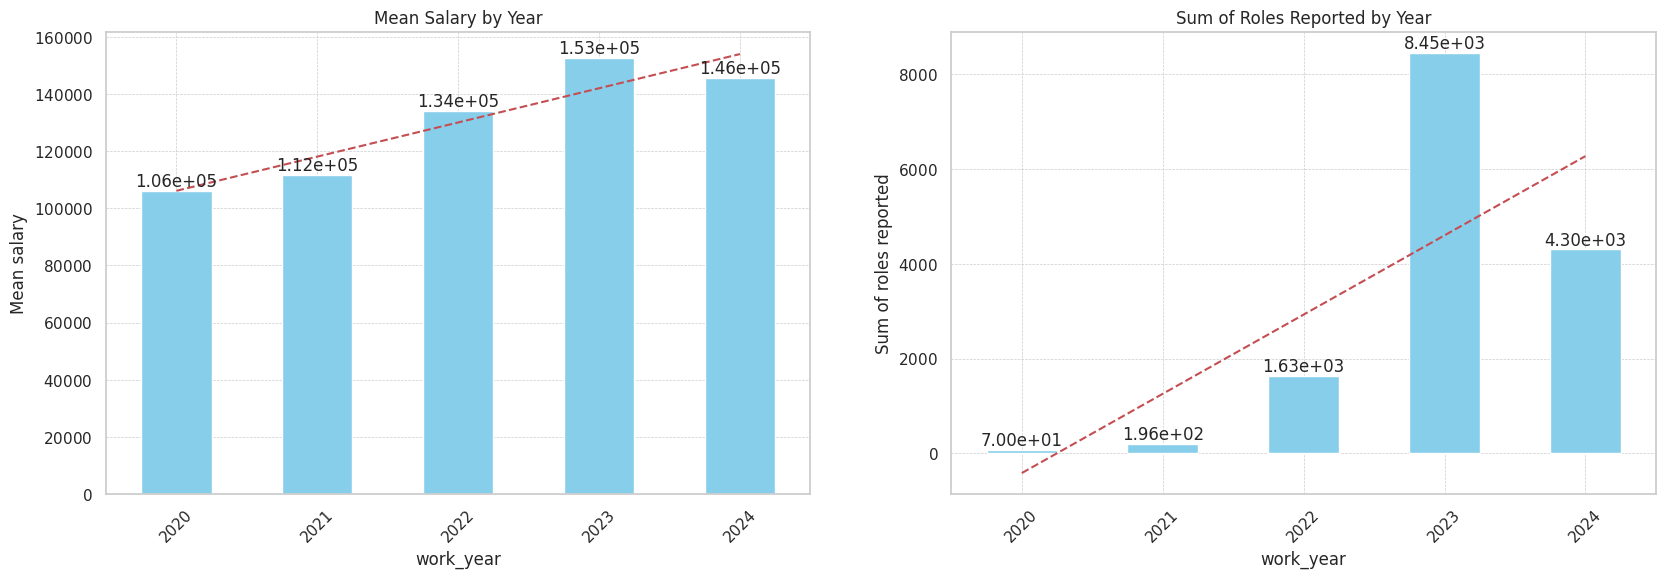

In [27]:
avg_salary_by_year = df[['work_year', 'salary']].groupby(['work_year']).mean()
positions_by_year = df[['work_year', 'experience_level']].groupby(['work_year']).count()

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plot_positions_with_trend(axs[0], avg_salary_by_year, 'salary', 'Mean salary', 'Mean Salary by Year')
plot_positions_with_trend(axs[1], positions_by_year, 'experience_level', 'Sum of roles reported', 'Sum of Roles Reported by Year')

plt.show()

## Experience Level Insights
3. **How does the average salary differ between junior and senior data science roles, and what factors contribute to the disparity?**
4. **Which experience level has seen the greatest increase in salaries over the covered years, and what could explain this trend?**



/tmp/ipykernel_198499/1460939476.py:45: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(data=data, x=x_col, y=y_col, hue=hue_col, ax=ax, palette=palette, hue_order=hue_order, width=0.9)


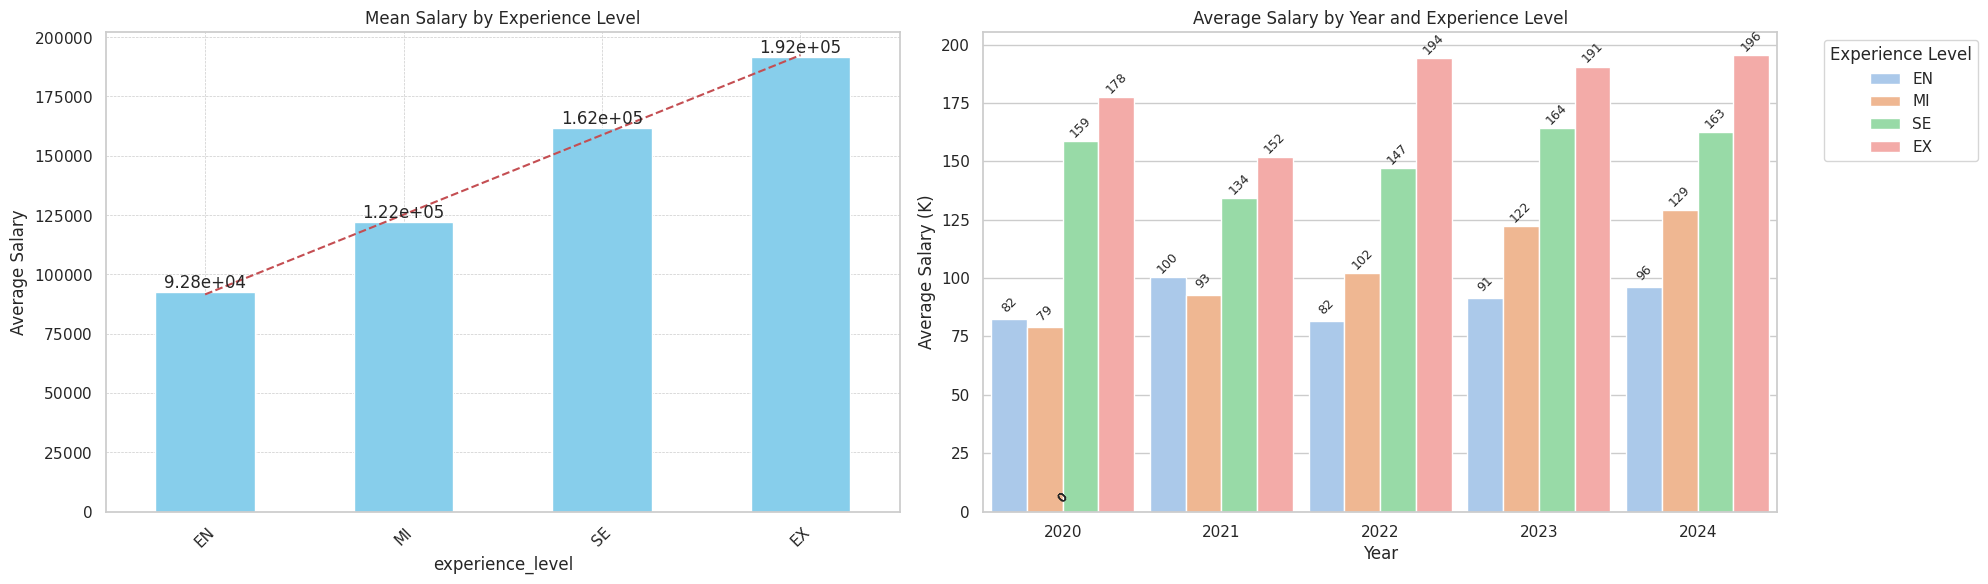

In [28]:
# Assuming 'df' is your original DataFrame
xp_level_x_salary = df[['experience_level', 'salary']].groupby(['experience_level']).mean().reindex(['EN', 'MI', 'SE', 'EX'])
average_salary_by_year_by_xp_level = df.groupby(['work_year', 'experience_level'])['salary'].mean().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plot_positions_with_trend(axs[0], xp_level_x_salary, 'salary', 'Average Salary','Mean Salary by Experience Level')

# Utilizando a função generalizada para o segundo gráfico
plot_bar_with_trend_and_annotations(axs[1], average_salary_by_year_by_xp_level, 'work_year', 'salary', 'experience_level', 'Experience Level', 'Year', 'Average Salary')

plt.tight_layout()
plt.show()